In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Hypothèses DEAP
SR = 128  # Hz 
NOTCH_HZ = 50  # réseau en Europe
BANDPASS = (1, 40)  # bande utile EEG

DATA_PATH = Path("features_raw.csv")


In [ ]:
df = pd.read_csv(DATA_PATH)


df = df.loc[:, ~df.columns.str.contains(r'^Unnamed')].copy()

print("Shape:", df.shape)
display(df.head(3))
display(df.describe().T.iloc[:10]) 

Shape: (8064, 32)


,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2
0,0.057813,-1.335266,4.640480,0.219573,7.473817,2.314842,1.918097,-9.257533,9.089943,-7.104519,...,-30.579542,-2.241480,1.415335,2.406646,12.864059,4.021099,-2.828598,-2.588735,2.637905,-5.226618
1,1.367408,10.259654,3.345409,7.897852,-2.446051,-1.655035,-6.301423,-7.290317,-3.546453,-5.705187,...,-1.290516,-2.568397,-5.651418,-0.096730,-4.930759,-1.722504,-6.111309,0.094893,-3.521353,1.887093
2,-1.783132,4.133553,-0.951680,-1.624803,-1.827309,-2.280364,-2.279225,9.151344,-0.239575,-0.057604,...,11.424923,-2.132823,-0.521117,8.605298,-4.499946,-3.232839,-4.249645,-3.687167,-7.383004,-4.489537


,count,mean,std,min,25%,50%,75%,max
Fp1,8064.0,-0.030110,4.303870,-21.068011,-2.741710,0.065934,2.800696,18.633981
AF3,8064.0,0.049626,19.050580,-174.162043,-6.946013,0.079142,7.236850,128.729493
F3,8064.0,-0.000615,4.949803,-32.576432,-2.907836,0.016822,2.968202,33.843385
F7,8064.0,0.012063,19.530056,-119.687503,-8.685504,0.050682,8.973624,120.164457
FC5,8064.0,-0.072324,14.974316,-104.400666,-5.854239,-0.196773,5.405050,140.707711
FC1,8064.0,-0.005855,5.223861,-31.009221,-2.613004,-0.023871,2.623072,38.313366
C3,8064.0,-0.051846,14.165469,-102.940922,-4.874130,-0.055134,4.686449,133.738083
T7,8064.0,0.080661,20.447003,-175.751521,-9.294624,0.028703,9.383725,129.284111
CP5,8064.0,-0.123370,24.640017,-181.618505,-7.736768,-0.234875,7.317881,247.950230
CP1,8064.0,0.048696,12.291358,-107.664139,-5.723207,0.190146,5.932243,86.087539


# Etape 1

In [3]:
""" 
Sépare les canaux EEG (Fp1, Fz, O1, etc.) des métadonnées (id sujet, essai, labels) si elles existent.

Les noms de canaux correspondent au système 10–20 (frontal F…, central C…, pariétal P…, occipital O…, z = axe médian).

"""

KNOWN_CHANNELS = [
    'Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz',
    'Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2'
]
channels = [c for c in df.columns if c in KNOWN_CHANNELS]
meta_cols = [c for c in df.columns if c not in channels]

print("Channels:", len(channels), channels[:8], "...")
print("Meta cols:", meta_cols)

Channels: 32 ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7'] ...
Meta cols: []


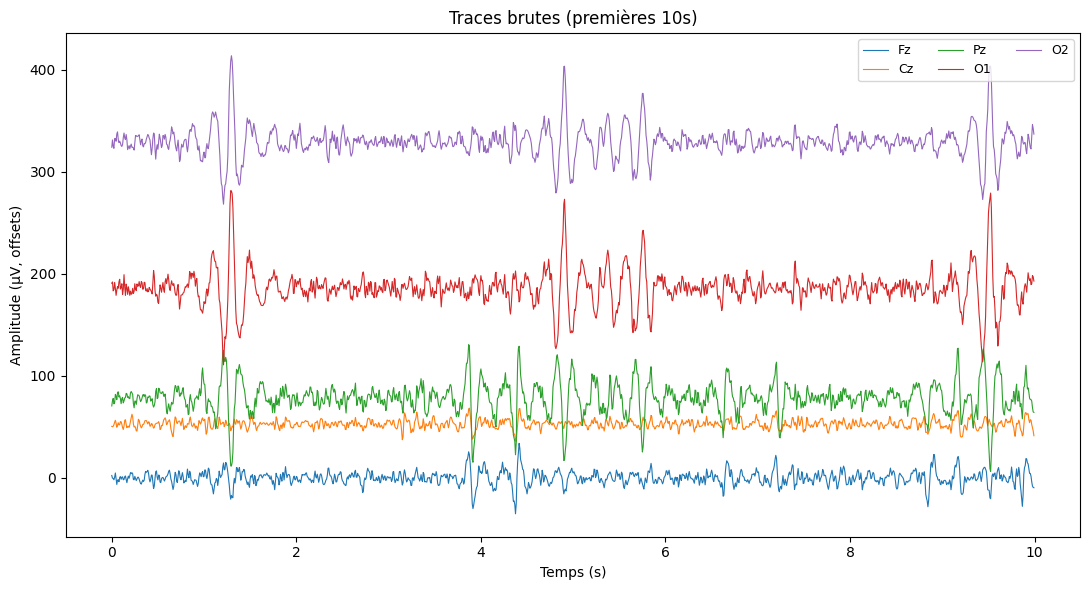

In [ ]:
""" 
Sélectionne quelques canaux (Fz, Cz, Pz, O1, O2), prend N secondes (= 10 s) et superpose leurs traces avec des offsets.

"""

N_SECONDS = 10
N_SAMPLES = N_SECONDS * SR

sel_channels = ['Fz','Cz','Pz','O1','O2']  
plot_df = df[sel_channels].iloc[:N_SAMPLES].reset_index(drop=True)

t = np.arange(len(plot_df)) / SR  # axe temporel en secondes

plt.figure(figsize=(11, 6))
offset = 0
for ch in sel_channels:
    plt.plot(t, plot_df[ch] + offset, label=ch, lw=0.8)
    offset += plot_df[ch].abs().max() * 1.5  # offset visuel

plt.title(f"Traces brutes (premières {N_SECONDS}s)")
plt.xlabel("Temps (s)"); plt.ylabel("Amplitude (µV, offsets)")
plt.legend(loc="upper right", ncol=3, fontsize=9)
plt.tight_layout(); plt.show()

Grands transitoires (pics rapides) visibles surtout sur O1/O2 et Pz.

Sur des occipitaux, ça peut être mouvement, électrode qui “pop”, parfois activité musculaire/clignements qui “débordent” jusqu’en postérieur si montage instable.

Des clignements typiques sont lents et dominent souvent Fp1/Fp2 , ici les pics semblent plus abrupts -> plutôt mouvement/artefact que blink “classique”.

Cz/Fz ont une amplitude plus faible et régulière -> bon signe (moins d’artefacts à ce moment).

Échelle : on lit des dizaines à centaines de µV (normal pour  artefacts), EEG “neuro” propre  < ±100 µV, mais les transitoires peuvent dépasser.

prétraitement

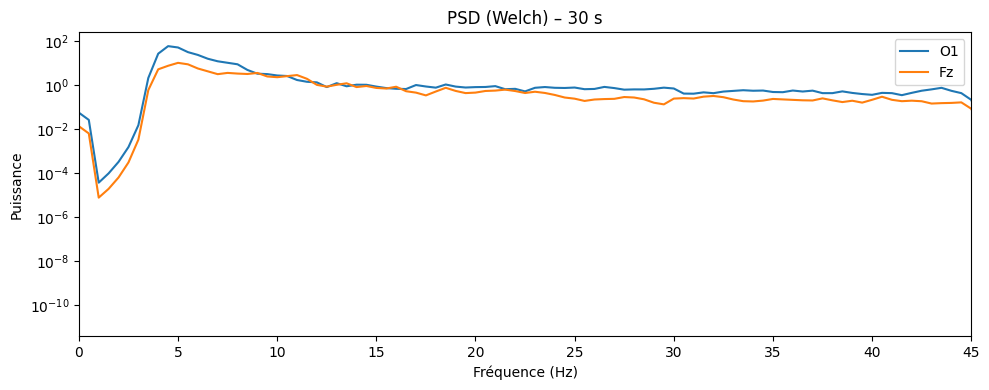

In [ ]:
""" 
Calcule la densité spectrale de puissance (PSD) par la méthode de Welch (moyenne de FFT sur fenêtres).

Compare un occipital (O1) et un frontal (Fz) sur 30 s.

PSD montre où se trouve l’énergie en fréquence .

Indispensable pour vérifier le 50 Hz, repérer un pic alpha (repos yeux fermés), définir bandes pour les features.

"""

from scipy.signal import welch

def psd_welch(x, fs=SR, nperseg=SR*2):  # 2s par segment
    f, Pxx = welch(x, fs=fs, nperseg=nperseg)
    return f, Pxx

chan_a = 'O1' if 'O1' in channels else channels[0]
chan_b = 'Fz' if 'Fz' in channels else channels[min(1,len(channels)-1)]

x_a = df[chan_a].iloc[:SR*30].values  # 30 s
x_b = df[chan_b].iloc[:SR*30].values

f_a, p_a = psd_welch(x_a, fs=SR)
f_b, p_b = psd_welch(x_b, fs=SR)

plt.figure(figsize=(10,4))
plt.semilogy(f_a, p_a, label=chan_a)
plt.semilogy(f_b, p_b, label=chan_b)
plt.xlim(0, 45)
plt.title("PSD (Welch) – 30 s")
plt.xlabel("Fréquence (Hz)"); plt.ylabel("Puissance")
plt.legend(); plt.tight_layout(); plt.show()


Grosse énergie basses fréquences (<6–7 Hz)

Pas de pic alpha évident à 8–12 Hz normal si ce segment n’est pas du repos yeux fermés.

Au-delà de 30–40 Hz, la puissance chute cohérent avec un filtrage implicite ou juste la nature du signal.

On ne voit pas de crête très fine à 50 Hz (bruit secteur) -> soit il est faible ici, soit dilué par Welch.

In [8]:
nan_rate = df[channels].isna().mean().sort_values(ascending=False)
print("Taux de NaN par canal (top 5):")
display(nan_rate.head())

amp = df[channels].abs().max().sort_values(ascending=False)
print("Amplitude max absolue par canal (top 5):")
display(amp.head())


Taux de NaN par canal (top 5):


Fp1    0.0
AF3    0.0
PO4    0.0
P8     0.0
P4     0.0
dtype: float64

Amplitude max absolue par canal (top 5):


FC2    839.742441
CP6    366.740914
PO4    361.662396
CP5    247.950230
FC6    242.785582
dtype: float64

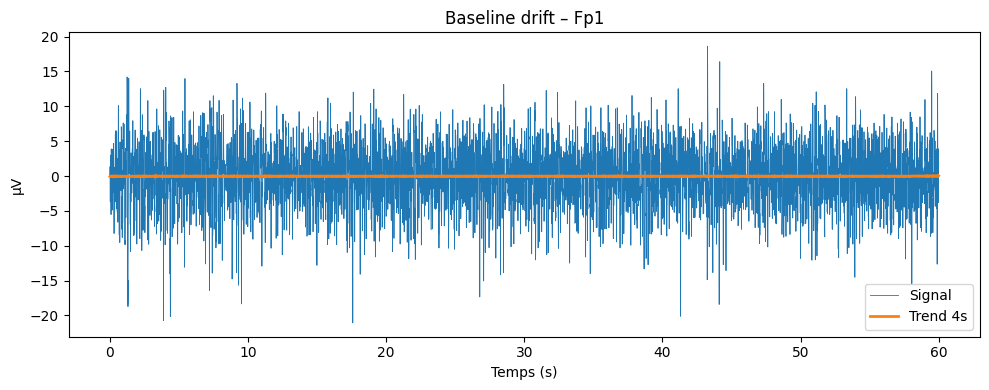

In [ ]:
""" 
Trace Fp1 sur 60 s + une moyenne glissante 4 s (tendance lente).

"""

win = SR * 4  # moyenne mobile 4s
ch = 'Fp1' if 'Fp1' in channels else channels[0]
x = df[ch].values[:SR*60]  
trend = pd.Series(x).rolling(win, min_periods=1, center=True).mean().values

plt.figure(figsize=(10,4))
plt.plot(np.arange(len(x))/SR, x, lw=0.6, label='Signal')
plt.plot(np.arange(len(x))/SR, trend, lw=2, label='Trend 4s')
plt.title(f"Baseline drift – {ch}")
plt.xlabel("Temps (s)"); plt.ylabel("µV")
plt.legend(); plt.tight_layout(); plt.show()


La courbe orange (trend 4 s) est plate -> peu de dérive visible sur cette minute.

L’amplitude instantanée (bleu) reste dans une plage raisonnable (quelques µV à ~±10 µV en moyenne, avec pointes).

## Appris :

Lire une trace multi-canaux et repérer artefacts évidents (mouvements/pops).

Lire une PSD (Welch) et situer les bandes (θ/α/β) + vérifier la présence/absence de pic alpha selon paradigme.

Vérifier la dérive de base et justifier un passe-haut (1 Hz).


# Etape 2

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import butter, filtfilt, iirnotch, welch


SR = 128            
BANDPASS = (1, 40)  
NOTCH_HZ = 50        # 50 Hz en Europe
WIN_SEC = 2.0        # fenêtre d'analyse (secondes)
HOP_SEC = 1.0        # pas entre fenêtres (overlap 50%)
N_PERSEG = int(SR * 2)  # pour Welch, 2 s par segment

DATA_PATH = Path("features_raw.csv")

KNOWN_CHANNELS = [
    'Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz',
    'Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2'
]


FRONTAL = ['Fz','F3','F4']
OCCIPITAL = ['O1','O2','Oz','PO3','PO4','Pz','P3','P4']



On fixe SR, filtres et tailles de fenêtres. Le passe-bande 1–40 Hz stabilise les features EEG, le notch 50 Hz enlève le secteur, et les fenêtres 2 s sont un standard pour PSD/band-power.

In [ ]:
df = pd.read_csv(DATA_PATH)
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed')].copy()

channels = [c for c in df.columns if c in KNOWN_CHANNELS]
meta_cols = [c for c in df.columns if c not in channels]

print("Channels:", len(channels))
print("Meta cols:", meta_cols)

# On essaie de détecter des métadonnées minimales ; sinon on crée des placeholders
subject_col = None
trial_col = None
label_col = None
for c in meta_cols:
    lc = c.lower()
    if 'sub' in lc or 'participant' in lc or 'subject' in lc:
        subject_col = c
    if 'trial' in lc or 'video' in lc or 'stim' in lc:
        trial_col = c
    if 'label' in lc or 'valence' in lc or 'arousal' in lc or 'emotion' in lc:
        label_col = c

# Placeholders 
if subject_col is None:
    df['subject'] = 0
    subject_col = 'subject'
if trial_col is None:
    df['trial'] = 0
    trial_col = 'trial'
if label_col is None:
    # pas de label NaN
    df['label'] = np.nan
    label_col = 'label'

print("Using meta:", subject_col, trial_col, label_col)


Channels: 32
Meta cols: []
Using meta: subject trial label


In [13]:
def notch_filter(x, fs=SR, f0=NOTCH_HZ, Q=30.0):
    # Filtre notch (IIR) : atténue finement 50 Hz
    b, a = iirnotch(w0=f0, Q=Q, fs=fs)
    return filtfilt(b, a, x)

def bandpass_filter(x, fs=SR, low=1.0, high=40.0, order=4):
    # Butterworth + filtfilt (zéro-phase)
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, x)

def average_reference(X):
    # Re-référencement à la moyenne : soustrait la moyenne instantanée sur les canaux
    # X: (T, C) -> retourne (T, C)
    mean = np.nanmean(X, axis=1, keepdims=True)
    return X - mean

# Appliquer les filtres canal par canal
X = df[channels].values.astype(float)      # (T, C)
T, C = X.shape

# Notch
for c in range(C):
    X[:, c] = notch_filter(X[:, c], fs=SR, f0=NOTCH_HZ)

# Band-pass
for c in range(C):
    X[:, c] = bandpass_filter(X[:, c], fs=SR, low=BANDPASS[0], high=BANDPASS[1])

# Re-référencement (option recommandé)
X = average_reference(X)

# DataFrame filtré + métadonnées conservées
df_filt = pd.DataFrame(X, columns=channels)
df_filt[subject_col] = df[subject_col].values
df_filt[trial_col] = df[trial_col].values
df_filt[label_col] = df[label_col].values

df_filt.head()


,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,T8,CP6,CP2,P4,P8,PO4,O2,subject,trial,label
0,-0.323707,-0.383506,0.123007,-0.448439,-0.467839,0.095211,-0.266200,1.037781,-0.158927,0.647849,...,-0.214895,-0.484080,-0.186969,-0.131572,-0.192791,-0.997058,-0.262396,0,0,NaN
1,0.988753,10.029988,-2.247062,4.287946,-11.426506,-4.019184,-8.452435,4.625474,-12.540635,3.297702,...,-0.034190,-18.719328,-6.599147,-3.349595,1.329058,-9.053041,5.488360,0,0,NaN
2,-2.619586,5.390017,-4.197341,0.355304,-7.018695,-4.134439,-3.657016,16.135289,-7.868480,5.501756,...,4.722767,-14.667368,-5.917289,-1.673816,-0.319250,-8.293443,0.595810,0,0,NaN
3,-3.357393,1.639157,-1.423853,2.030946,0.557225,-1.014618,3.588341,22.906947,-0.173960,4.824971,...,-7.358057,-6.378320,-2.213263,1.171718,0.469561,-0.581685,-0.689218,0,0,NaN
4,1.598929,5.370306,0.860751,5.476971,-4.937166,1.121916,2.155854,12.688887,-2.574710,6.083334,...,-27.232733,-10.845648,-2.072613,2.426983,3.616527,1.475026,6.177494,0,0,NaN


Notch supprime la raie du secteur (50 Hz).

Passe-bande 1–40 Hz garde l’EEG utile (delta–beta), enlève dérive & bruit HF.

Re-référencement stabilise les canaux en supprimant une composante commune.

In [ ]:
WIN = int(WIN_SEC * SR)
HOP = int(HOP_SEC * SR)

def window_indices(n, win=WIN, hop=HOP):
    i = 0
    while i + win <= n:
        yield i, i + win
        i += hop

# subject, trial, window_id
subs = df_filt[subject_col].values
trials = df_filt[trial_col].values
labels = df_filt[label_col].values


rows = []
for (i0, i1) in window_indices(len(df_filt), WIN, HOP):
    rows.append({
        'subject': subs[i0],
        'trial': trials[i0],
        'label': labels[i0],
        'i0': i0, 'i1': i1
    })
win_df = pd.DataFrame(rows)
win_df.head(), win_df.shape


(   subject  trial  label   i0   i1
 0        0      0    NaN    0  256
 1        0      0    NaN  128  384
 2        0      0    NaN  256  512
 3        0      0    NaN  384  640
 4        0      0    NaN  512  768,
 (62, 5))

Le fenêtrage rend le signal stationnaire localement et permet de calculer des features (PSD, band-powers) par fenêtre. L’overlap 50% lisse la dynamique.

In [ ]:
def psd_welch_arr(x_win, fs=SR, nperseg=N_PERSEG):
    # x_win: (W, T) -> retourne (W, Freqs), (W, PSD[F])
    # moyenne sur le temps de la fenêtre
    f, Pxx = welch(x_win, fs=fs, nperseg=min(nperseg, x_win.shape[1]), axis=1)
    return f, Pxx  # Pxx shape: (W, F)

def bandpower_from_psd(freqs, psd, fmin, fmax):
    m = (freqs >= fmin) & (freqs <= fmax)
    return psd[:, m].mean(axis=1)

# On construit matrice fenêtres x canaux pour calculer les band-powers
W = len(win_df)
C = len(channels)
theta_bp = np.zeros((W, C))
alpha_bp = np.zeros((W, C))
beta_bp  = np.zeros((W, C))

for ci, ch in enumerate(channels):
    # Empile toutes les fenêtres de ce canal
    Xw = np.stack([df_filt[ch].values[s:e] for s, e in zip(win_df['i0'], win_df['i1'])], axis=0)  # (W, WIN)
    freqs, psd = psd_welch_arr(Xw, fs=SR, nperseg=N_PERSEG)  # (W, F)
    theta_bp[:, ci] = bandpower_from_psd(freqs, psd, 4, 7)
    alpha_bp[:, ci] = bandpower_from_psd(freqs, psd, 8, 13)
    beta_bp[:,  ci] = bandpower_from_psd(freqs, psd, 13, 30)


La PSD de Welch moyenne des FFT pour réduire la variance -> band-powers θ, α, β robustes aux petites variations. On le fait par fenêtre et par canal.

In [18]:
POST = [ch for ch in OCCIPITAL if ch in channels]  # canaux dispo
if len(POST) == 0:
    POST = [ch for ch in ['O1','O2','Oz','Pz'] if ch in channels]

def peak_alpha_freq(freqs, psd_row, fmin=8, fmax=13):
    m = (freqs >= fmin) & (freqs <= fmax)
    if psd_row[:, m].shape[1] == 0:
        return np.nan
    # pic de la moyenne postérieure
    mean_post = psd_row[:, m].mean(axis=0)  # (Fsel,)
    return freqs[m][np.argmax(mean_post)]

# On calcule un PAF par fenêtre (moyenné sur les canaux postérieurs)
paf = np.zeros(W)
for wi in range(W):
    # empile PSD de chaque canal POST pour cette fenêtre
    Xw = np.stack([df_filt[ch].values[s:e] for ch in POST for s, e in [(win_df['i0'].iat[wi], win_df['i1'].iat[wi])]], axis=0)
    f, Pxx = welch(Xw, fs=SR, nperseg=min(N_PERSEG, Xw.shape[1]), axis=1)
    # PAF fenêtre = pic alpha de la moyenne postérieure
    paf[wi] = peak_alpha_freq(f, Pxx, 8, 13)


Le PAF (fréquence du pic alpha) est un paramètre interprétable lié à la vigilance/âge. Ici, on le calcule par fenêtre comme le pic du moyen postérieur.

In [19]:
# Moyennes régionales utiles
def mean_region(bp_mat, region_list):
    idx = [channels.index(ch) for ch in region_list if ch in channels]
    if len(idx) == 0:
        return np.full((W,), np.nan)
    return bp_mat[:, idx].mean(axis=1)

# Indices simples
alpha_occ = mean_region(alpha_bp, OCCIPITAL)     # alpha moyen occipital
theta_fr  = mean_region(theta_bp, FRONTAL)       # theta frontal
beta_fr   = mean_region(beta_bp, FRONTAL)        # beta frontal
ratio_thb_fr = theta_fr / (beta_fr + 1e-8)       # ratio theta/beta frontal


Les agrégats régionaux (occipital/frontal) sont stables et interprétables. Le ratio θ/β frontal est un classique “exécutif/vigilance”.

In [ ]:
# On garde aussi 2–3 canaux bruts de band-power (ex: Fz, Cz, O1) pour inspection
keep_ch = [ch for ch in ['Fz','Cz','O1','O2','Pz'] if ch in channels]
cols = []
for ch in keep_ch:
    cols += [f'theta_{ch}', f'alpha_{ch}', f'beta_{ch}']

feat = pd.DataFrame({
    'subject': win_df['subject'].values,
    'trial':   win_df['trial'].values,
    'label':   win_df['label'].values,
    'alpha_occ': alpha_occ,
    'theta_fr': theta_fr,
    'beta_fr': beta_fr,
    'ratio_thb_fr': ratio_thb_fr,
    'paf_post': paf
})

# Ajouter  canaux
for ch in keep_ch:
    ci = channels.index(ch)
    feat[f'theta_{ch}'] = theta_bp[:, ci]
    feat[f'alpha_{ch}'] = alpha_bp[:, ci]
    feat[f'beta_{ch}']  = beta_bp[:, ci]

feat.head(), feat.shape


(   subject  trial  label  alpha_occ    theta_fr   beta_fr  ratio_thb_fr  \
 0        0      0    NaN  20.742132   97.330447  0.539681    180.348190   
 1        0      0    NaN   3.578346   13.666213  0.376638     36.284762   
 2        0      0    NaN   1.670159    4.126520  0.401517     10.277334   
 3        0      0    NaN  12.770712   34.576567  1.259903     27.443838   
 4        0      0    NaN  25.631334  110.449651  0.946817    116.653678   
 
    paf_post   theta_Fz  alpha_Fz  ...   beta_Cz    theta_O1   alpha_O1  \
 0       8.0   7.088176  1.637628  ...  0.445434  191.909718   9.036821   
 1       8.0   1.436007  0.774645  ...  0.182179   25.493086   1.845432   
 2       8.0   1.522749  0.556524  ...  0.422505    2.978382   1.520351   
 3       8.5  24.103953  5.290833  ...  0.296692    7.773845   2.450756   
 4       8.0   6.186903  0.726803  ...  0.156250  193.546134  10.962937   
 
     beta_O1    theta_O2   alpha_O2   beta_O2    theta_Pz   alpha_Pz   beta_Pz  
 0  0.951

On construit une table propre de features, prête pour l’évaluation  : indicateurs régionaux, PAF, et quelques band-powers canal-spécifiques.

In [ ]:
OUT_PATH = DATA_PATH.parent / "features_windows.parquet"
feat.to_parquet(OUT_PATH, index=False, engine='fastparquet')
print("Saved:", OUT_PATH)

# Sanity check
feat[['alpha_occ','ratio_thb_fr','paf_post']].describe()

Saved: /Users/jerometam/Desktop/Bureau - MacBook Pro de Jerome/GitHubScript/EEGSignal/features_windows.parquet


,alpha_occ,ratio_thb_fr,paf_post
count,62.000000,62.000000,62.000000
mean,5.102870,30.133524,8.870968
std,5.409941,40.032297,1.155654
min,0.943949,0.891009,8.000000
25%,1.738590,5.506299,8.000000
50%,2.944526,13.138668,8.500000
75%,6.705514,23.841044,9.500000
max,25.631334,180.348190,12.500000


## Note
 
Notch + band-pass + re-ref : c’est le socle EEG avant tout calcul de features.

Fenêtrage 2 s (overlap 50%) : compromis entre stabilité des PSD et réactivité.

Band-powers θ/α/β : features simples, interprétables et robustes.

PAF postérieur : utile (surtout en repos), facile à calculer.

Ratios & moyennes régionales (θ/β frontal, α occipital) : bons candidats d’indice “temps réel”.

# Etape 3 

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import butter, filtfilt, iirnotch, welch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (10,4)


DATA = Path("features_raw.csv")

SR = 128          
BANDPASS = (1,40)  
NOTCH_HZ = 50      
WIN_SEC = 2.0      
HOP_SEC = 1.0     
N_PERSEG = int(SR*2) 

KNOWN_CHANNELS = [
    'Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz',
    'Fp2','AF4','Fz','F4','F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2'
]
FRONTAL   = [c for c in ['Fz','F3','F4'] if c in KNOWN_CHANNELS]
OCCIPITAL = [c for c in ['O1','O2','Oz','PO3','PO4','Pz'] if c in KNOWN_CHANNELS]


on fixe une config standard (1–40 Hz + notch 50 Hz, fenêtres 2 s) et on liste les canaux utiles par régions.

In [ ]:

df = pd.read_csv(DATA)
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed')].copy()

channels = [c for c in df.columns if c in KNOWN_CHANNELS]
assert len(channels) >= 8, f"Peu de canaux détectés: {channels}"

print("Shape:", df.shape, "| channels:", len(channels))
display(df[channels].head())
display(df[channels].describe().T.head(8))


Shape: (8064, 32) | channels: 32


,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2
0,0.057813,-1.335266,4.640480,0.219573,7.473817,2.314842,1.918097,-9.257533,9.089943,-7.104519,...,-30.579542,-2.241480,1.415335,2.406646,12.864059,4.021099,-2.828598,-2.588735,2.637905,-5.226618
1,1.367408,10.259654,3.345409,7.897852,-2.446051,-1.655035,-6.301423,-7.290317,-3.546453,-5.705187,...,-1.290516,-2.568397,-5.651418,-0.096730,-4.930759,-1.722504,-6.111309,0.094893,-3.521353,1.887093
2,-1.783132,4.133553,-0.951680,-1.624803,-1.827309,-2.280364,-2.279225,9.151344,-0.239575,-0.057604,...,11.424923,-2.132823,-0.521117,8.605298,-4.499946,-3.232839,-4.249645,-3.687167,-7.383004,-4.489537
3,-3.690217,-0.814000,2.295469,0.901445,8.323679,1.127906,6.356886,11.642082,9.354154,-1.662478,...,-14.721411,-0.506117,-1.154866,-3.940251,7.390881,2.129897,-0.794675,-1.959021,2.774530,-6.323060
4,2.137114,6.420466,6.122230,10.015321,3.106394,3.183129,3.658535,4.571793,4.917712,-2.325940,...,-13.815090,1.813907,-6.444635,-27.680880,0.641364,1.996658,-0.445779,2.614021,6.161845,3.308816


,count,mean,std,min,25%,50%,75%,max
Fp1,8064.0,-0.030110,4.303870,-21.068011,-2.741710,0.065934,2.800696,18.633981
AF3,8064.0,0.049626,19.050580,-174.162043,-6.946013,0.079142,7.236850,128.729493
F3,8064.0,-0.000615,4.949803,-32.576432,-2.907836,0.016822,2.968202,33.843385
F7,8064.0,0.012063,19.530056,-119.687503,-8.685504,0.050682,8.973624,120.164457
FC5,8064.0,-0.072324,14.974316,-104.400666,-5.854239,-0.196773,5.405050,140.707711
FC1,8064.0,-0.005855,5.223861,-31.009221,-2.613004,-0.023871,2.623072,38.313366
C3,8064.0,-0.051846,14.165469,-102.940922,-4.874130,-0.055134,4.686449,133.738083
T7,8064.0,0.080661,20.447003,-175.751521,-9.294624,0.028703,9.383725,129.284111


on isole uniquement les colonnes EEG et on vérifie des stats de base.

In [ ]:

def notch_filter(x, fs=SR, f0=NOTCH_HZ, Q=30.0):
    b, a = iirnotch(w0=f0, Q=Q, fs=fs);  return filtfilt(b, a, x)

def bandpass_filter(x, fs=SR, low=1.0, high=40.0, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band');  return filtfilt(b, a, x)

def average_reference(X):
    m = np.nanmean(X, axis=1, keepdims=True);  return X - m


X = df[channels].astype(float).values 
for c in range(X.shape[1]):
    X[:,c] = notch_filter(X[:,c])
    X[:,c] = bandpass_filter(X[:,c])

X = average_reference(X)
df_filt = pd.DataFrame(X, columns=channels)
df_filt.head()


,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2
0,-0.323707,-0.383506,0.123007,-0.448439,-0.467839,0.095211,-0.266200,1.037781,-0.158927,0.647849,...,2.418829,0.667073,0.367111,-0.214895,-0.484080,-0.186969,-0.131572,-0.192791,-0.997058,-0.262396
1,0.988753,10.029988,-2.247062,4.287946,-11.426506,-4.019184,-8.452435,4.625474,-12.540635,3.297702,...,35.693373,0.311732,-4.954063,-0.034190,-18.719328,-6.599147,-3.349595,1.329058,-9.053041,5.488360
2,-2.619586,5.390017,-4.197341,0.355304,-7.018695,-4.134439,-3.657016,16.135289,-7.868480,5.501756,...,35.066219,0.435064,-2.803568,4.722767,-14.667368,-5.917289,-1.673816,-0.319250,-8.293443,0.595810
3,-3.357393,1.639157,-1.423853,2.030946,0.557225,-1.014618,3.588341,22.906947,-0.173960,4.824971,...,16.014907,1.733358,-3.411998,-7.358057,-6.378320,-2.213263,1.171718,0.469561,-0.581685,-0.689218
4,1.598929,5.370306,0.860751,5.476971,-4.937166,1.121916,2.155854,12.688887,-2.574710,6.083334,...,18.722945,4.544221,-5.029562,-27.232733,-10.845648,-2.072613,2.426983,3.616527,1.475026,6.177494


standard EEG , on stabilise le signal et on aligne les canaux autour d’une référence moyenne.

In [ ]:

WIN = int(WIN_SEC*SR); HOP = int(HOP_SEC*SR)

def window_bounds(n, win=WIN, hop=HOP):
    i=0
    while i+win <= n:
        yield i, i+win; i += hop

bounds = list(window_bounds(len(df_filt)))
len(bounds), bounds[:3]


(62, [(0, 256), (128, 384), (256, 512)])

les features fréquence se calculent sur des segments courts où le signal est quasi stationnaire.

In [ ]:

def welch_windows(x_win, fs=SR, nperseg=N_PERSEG):
    f, Pxx = welch(x_win, fs=fs, nperseg=min(nperseg, x_win.shape[1]), axis=1)
    return f, Pxx 

def bandpower_from_psd(freqs, psd, fmin, fmax):
    m = (freqs>=fmin) & (freqs<=fmax);  return psd[:,m].mean(axis=1)

W = len(bounds); C = len(channels)
theta = np.zeros((W,C)); alpha = np.zeros((W,C)); beta = np.zeros((W,C))

for ci, ch in enumerate(channels):
    Xw = np.stack([df_filt[ch].values[s:e] for s,e in bounds], axis=0)  
    f, P = welch_windows(Xw)
    theta[:,ci] = bandpower_from_psd(f,P,4,7)
    alpha[:,ci] = bandpower_from_psd(f,P,8,13)
    beta[:,ci]  = bandpower_from_psd(f,P,13,30)


bandes classiques interprétables et robustes (moyennes de PSD).

In [ ]:

POST = [c for c in ['O1','O2','Oz','PO3','PO4','Pz'] if c in channels]
def peak_alpha_freq(freqs, psd_row, fmin=8, fmax=13):
    m = (freqs>=fmin)&(freqs<=fmax)
    if psd_row.shape[1]==0 or m.sum()==0: return np.nan
    return freqs[m][ psd_row[:,m].mean(axis=0).argmax() ]

paf = np.zeros(W); 
for wi,(s,e) in enumerate(bounds):
    Xpost = np.stack([df_filt[ch].values[s:e] for ch in POST], axis=0)
    f, P = welch(Xpost, fs=SR, nperseg=min(N_PERSEG, Xpost.shape[1]), axis=1)
    paf[wi] = peak_alpha_freq(f, P, 8, 13)

def mean_region(bp, region):
    idx = [channels.index(ch) for ch in region if ch in channels]
    if not idx: return np.full((W,), np.nan)
    return bp[:,idx].mean(axis=1)

alpha_occ = mean_region(alpha, OCCIPITAL)
theta_fr  = mean_region(theta, FRONTAL)
beta_fr   = mean_region(beta,  FRONTAL)
ratio_thb_fr = theta_fr / (beta_fr + 1e-8)


PAF = “pic α” (utile pour la vigilance/âge). Les moyennes régionales et le ratio θ/β frontal sont des indices simples “prêts NF”.

In [ ]:

keep = [ch for ch in ['Fz','Cz','O1','O2','Pz'] if ch in channels]
feat = pd.DataFrame({
    'alpha_occ': alpha_occ,
    'theta_fr': theta_fr,
    'beta_fr': beta_fr,
    'ratio_thb_fr': ratio_thb_fr,
    'paf_post': paf,
})

for ch in keep:
    ci = channels.index(ch)
    feat[f'theta_{ch}'] = theta[:,ci]
    feat[f'alpha_{ch}'] = alpha[:,ci]
    feat[f'beta_{ch}']  = beta[:,ci]

feat.shape, feat.head()


((62, 20),
    alpha_occ    theta_fr   beta_fr  ratio_thb_fr  paf_post   theta_Fz  \
 0  24.234947   97.330447  0.539681    180.348190       8.0   7.088176   
 1   4.096142   13.666213  0.376638     36.284762       8.0   1.436007   
 2   1.928370    4.126520  0.401517     10.277334       8.0   1.522749   
 3  16.157970   34.576567  1.259903     27.443838       8.5  24.103953   
 4  30.024108  110.449651  0.946817    116.653678       8.0   6.186903   
 
    alpha_Fz   beta_Fz  theta_Cz  alpha_Cz   beta_Cz    theta_O1   alpha_O1  \
 0  1.637628  0.432659  0.492975  0.525537  0.445434  191.909718   9.036821   
 1  0.774645  0.234135  0.552920  0.422341  0.182179   25.493086   1.845432   
 2  0.556524  0.341226  0.970783  0.908242  0.422505    2.978382   1.520351   
 3  5.290833  0.667602  4.964587  1.794604  0.296692    7.773845   2.450756   
 4  0.726803  0.291687  0.685931  0.294266  0.156250  193.546134  10.962937   
 
     beta_O1    theta_O2   alpha_O2   beta_O2    theta_Pz   alpha_P

on obtient un set compact, interprétable et exploitable.

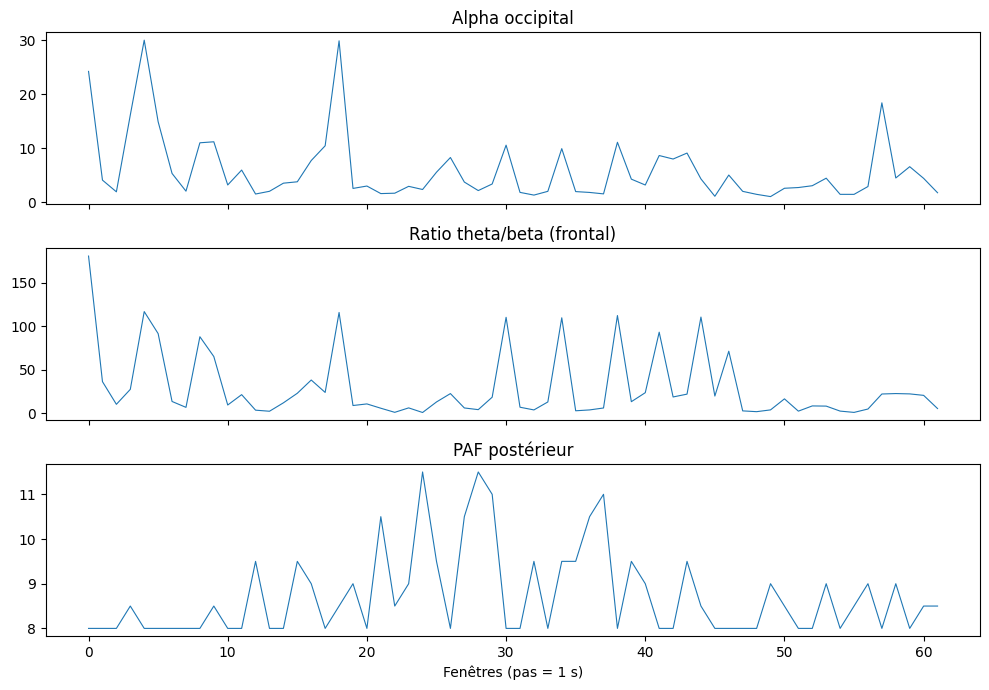

In [ ]:

fig,ax = plt.subplots(3,1,figsize=(10,7),sharex=True)
ax[0].plot(feat['alpha_occ'].values,lw=0.8); ax[0].set_title("Alpha occipital")
ax[1].plot(feat['ratio_thb_fr'].values,lw=0.8); ax[1].set_title("Ratio theta/beta (frontal)")
ax[2].plot(feat['paf_post'].values,lw=0.8); ax[2].set_title("PAF postérieur")
ax[2].set_xlabel("Fenêtres (pas = 1 s)"); plt.tight_layout(); plt.show()


 variabilité et sauts éventuels (artefacts) sur des indices simples.

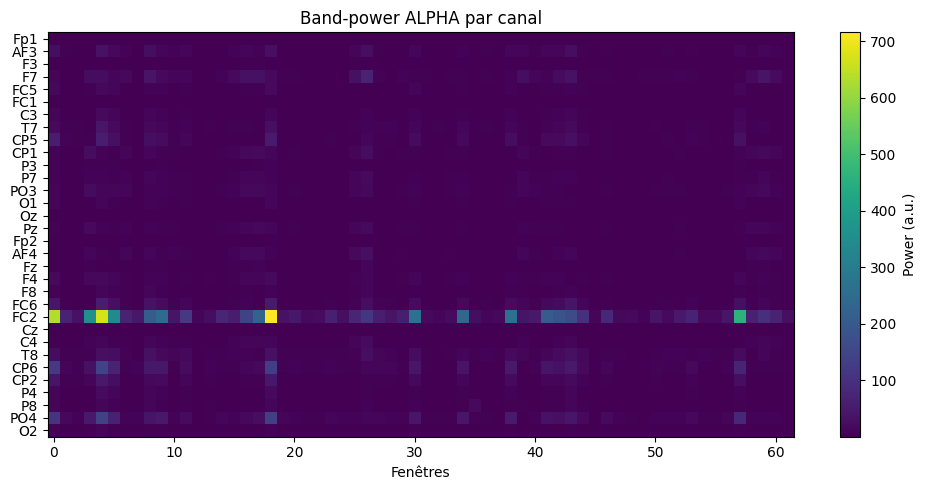

In [ ]:

alpha_df = pd.DataFrame(alpha, columns=channels)
plt.figure(figsize=(10,5))
plt.imshow(alpha_df.T, aspect='auto', interpolation='nearest')
plt.colorbar(label='Power (a.u.)'); plt.yticks(range(len(channels)), channels)
plt.xlabel("Fenêtres"); plt.title("Band-power ALPHA par canal"); plt.tight_layout(); plt.show()


repérer des canaux “forts/faibles” et des événements (blocs de haute puissance).

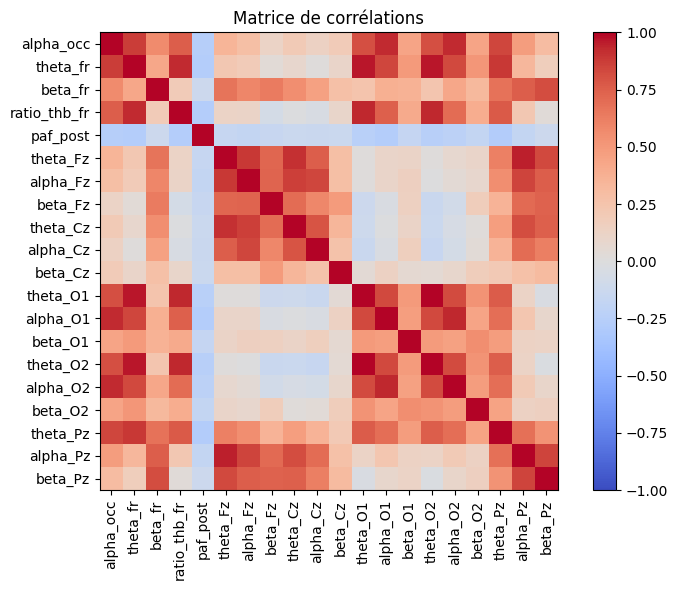

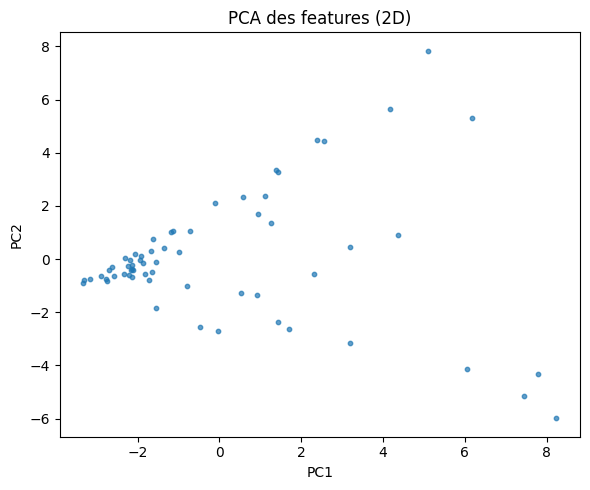

In [ ]:

corr = feat.corr(numeric_only=True)
plt.figure(figsize=(8,6)); plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(); plt.xticks(range(len(corr)), corr.columns, rotation=90); plt.yticks(range(len(corr)), corr.columns)
plt.title("Matrice de corrélations"); plt.tight_layout(); plt.show()


X = feat.fillna(feat.median()).values
Xz = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=0).fit_transform(Xz)
plt.figure(figsize=(6,5)); plt.scatter(pca[:,0], pca[:,1], s=10, alpha=0.7)
plt.title("PCA des features (2D)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()


corrélation = redondances , PCA = structure globale (mêmes features se regroupent).

/var/folders/5r/24m7lvfj73d6lk14htsllmww0000gn/T/ipykernel_20541/3406805737.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"C{k}" for k in sorted(feat['cluster'].unique())])


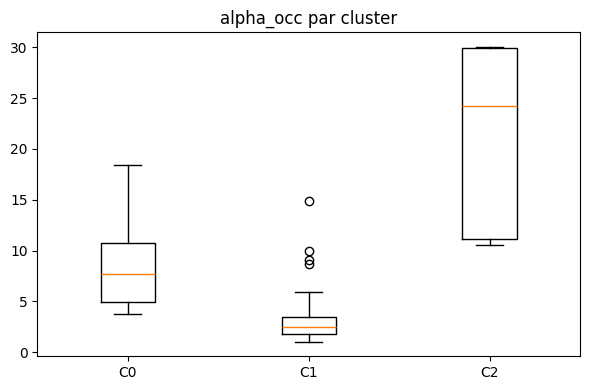

/var/folders/5r/24m7lvfj73d6lk14htsllmww0000gn/T/ipykernel_20541/3406805737.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"C{k}" for k in sorted(feat['cluster'].unique())])


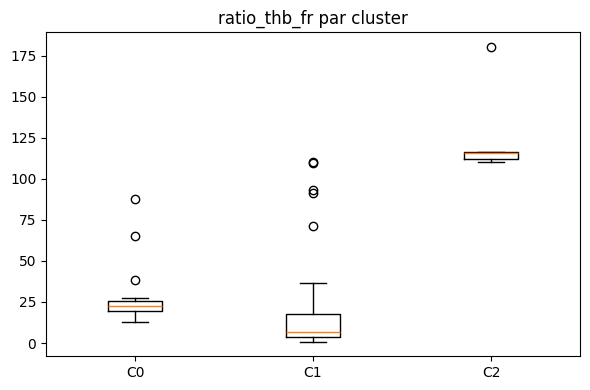

/var/folders/5r/24m7lvfj73d6lk14htsllmww0000gn/T/ipykernel_20541/3406805737.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"C{k}" for k in sorted(feat['cluster'].unique())])


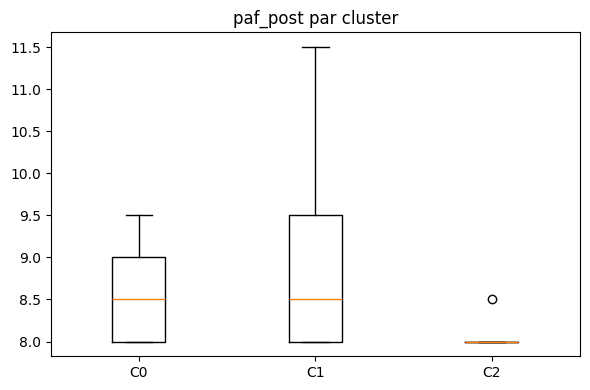

In [ ]:

km = KMeans(n_clusters=3, n_init=10, random_state=0)
cl = km.fit_predict(Xz)
feat['cluster'] = cl

for col in ['alpha_occ','ratio_thb_fr','paf_post']:
    plt.figure(figsize=(6,4))
    data = [feat.loc[feat['cluster']==k, col] for k in sorted(feat['cluster'].unique())]
    plt.boxplot(data, labels=[f"C{k}" for k in sorted(feat['cluster'].unique())])
    plt.title(f"{col} par cluster"); plt.tight_layout(); plt.show()


montrer que des profils spectro simples se regroupent spontanément (même sans labels).

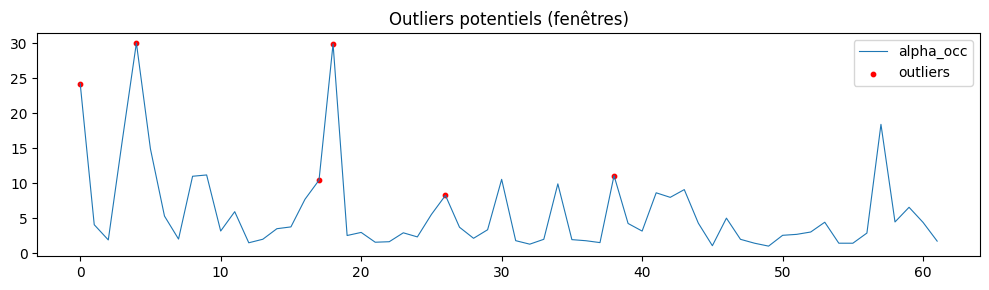

In [ ]:

z = np.abs(StandardScaler().fit_transform(X))
z_max = z.max(axis=1)
thr = 3.5  
bad_idx = np.where(z_max>thr)[0]
len(bad_idx), bad_idx[:10]


plt.figure(figsize=(10,3))
plt.plot(feat['alpha_occ'].values, lw=0.8, label='alpha_occ')
plt.scatter(bad_idx, feat['alpha_occ'].values[bad_idx], color='red', s=10, label='outliers')
plt.title("Outliers potentiels (fenêtres)"); plt.legend(); plt.tight_layout(); plt.show()


repérer des fenêtres anormales (souvent artefacts) à exclure ou down-weighter.

In [41]:
"""
# 12 - save
out_dir = DATA.parent
feat_path = out_dir / "features_windows.parquet"
feat.to_parquet(feat_path, index=False)

summary = feat.describe().T
sum_path = out_dir / "features_summary.csv"
summary.to_csv(sum_path)

feat_path, sum_path
 """


'\n# 12 - save\nout_dir = DATA.parent\nfeat_path = out_dir / "features_windows.parquet"\nfeat.to_parquet(feat_path, index=False)\n\nsummary = feat.describe().T\nsum_path = out_dir / "features_summary.csv"\nsummary.to_csv(sum_path)\n\nfeat_path, sum_path\n '



- Stabilité : si alpha_occ/ratio_thb_fr varient doucement, ce sont de bons candidats d’indice pour une jauge de feedback.

- PAF : sur DEAP (pas repos yeux fermés), il peut être instable.

- Heatmap : des bandes horizontales très chaudes sur certains canaux -> canaux “dominants” (ou artefacts périodiques).

- Corrélation : fort r entre alpha_occ et alpha_O1/O2 = normal (même famille).

- Clusters : si un cluster a alpha_occ >>, ça suggère des états plus “relax” (hypothèse), mais sans label on reste descriptif.